## Check the metrics for various split of the entire dataset

- This section is created to check density and coverage for the entire dataset
- The dataset is split based on various ```split_size``` using ```stratify```
- For each split, the density and coverage is computed.

#### Example: 
- for ```split_size``` of 0.4, the ```X_model``` has 42,000 images and ```X_validation``` has 28,000 images
- the tree is trained on the ```X_model```
- the query dataset is ```X_validation```

In [18]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)
myranges = np.linspace(0.05, 0.4, 10) 
density_check = []
coverage_check = []
val_length = []
for i in myranges:
        X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=i, random_state=42, stratify=np.array(Y))
        real = np.array(X_model).reshape(len(X_model), -1)
        gen = np.array(X_validation).reshape(len(X_validation), -1)
        den = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
        cov = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
        density_check.append(den); coverage_check.append(cov); val_length.append(len(X_validation))
        #print(f"Split size: {i:.2f} | Validation size: {len(X_validation)} | Density: {den:.5f} | Coverage: {cov:.5f}")

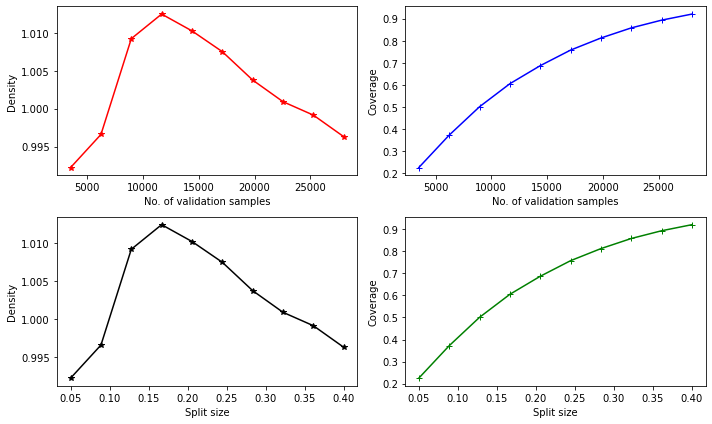

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].plot(val_length, density_check, 'r-*')
ax[0,0].set_xlabel("No. of validation samples")
ax[0,0].set_ylabel("Density")


ax[0,1].plot(val_length, coverage_check, 'b-+')
ax[0,1].set_xlabel("No. of validation samples")
ax[0,1].set_ylabel("Coverage")

ax[1,0].plot(myranges, density_check, 'k-*')
ax[1,0].set_xlabel("Split size")
ax[1,0].set_ylabel("Density")


ax[1,1].plot(myranges, coverage_check, 'g-+')
ax[1,1].set_xlabel("Split size")
ax[1,1].set_ylabel("Coverage")
fig.tight_layout()
plt.savefig("Metrics_for_different_splitsizes.png")

-----------------------------------------------------------------------------------------------------------------

## Check the coverage using only 2 classes from the dataset

- Only 2 classes i.e, ```class 0``` and ```class 1``` is considered and coverage is computed for both the cases

- ```coverage00``` -> tree is trained on the entire class 0 and the query dataset is also class 0
- ```coverage005``` -> tree is trained on the entire class 0 and the query dataset is 50% of samples from class 0
- ```coverage01``` -> tree is trained on the entire class 0 and the query dataset is the samples from class 1

- ```classCom``` -> the dataset is formed by combininf class 0 and class 1
- ```coveragecom``` -> tree is trained on the entire classCom and the query dataset is the samples from class 0
- ```coveragecom5``` -> tree is trained on the entire classCom and the query dataset is 10% of samples from class 0

In [6]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)

In [21]:
X = torch.from_numpy(np.array(X)).cpu(); Y=torch.from_numpy(np.array(Y)).cpu();
#print(np.unique(Y, return_counts=True)); 
class0 = np.where(Y==0)[0]; class1 = np.where(Y==1)[0]; #print(len(class0), len(class1)); 
newX = X.reshape(X.shape[0], -1); #print(newX.shape)

classCom = torch.from_numpy(np.vstack([newX[class0], newX[class1]])).cpu()

#newX[class0].shape
coverage00 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0], 'indexflatl2')
coverage005 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0][:3452,...], 'indexflatl2')
coverage01 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class1], 'indexflatl2')
coveragecom = gem_build_coverage(classCom, classCom.shape[0], newX[class0], 'indexflatl2')
coveragecom5 = gem_build_coverage(classCom, classCom.shape[0], newX[class0][:600,...], 'indexflatl2')
print(f"Coverage: \n Class 0 & Class 0: {coverage00} \n Class 0 & Class 0 (50%): {coverage005} \n" +
      f" Class 0 & Class 1: {coverage01} \n \n Class 0 + Class 1 combined: {coveragecom} \n" +
     f" Class 0 + Class 1 combined(10%): {coveragecom5}")

Coverage: 
 Class 0 & Class 0: 1.0 
 Class 0 & Class 0 (50%): 0.9701579213142395 
 Class 0 & Class 1: 0.0020281036850064993 
 
 Class 0 + Class 1 combined: 0.4673207104206085 
 Class 0 + Class 1 combined(10%): 0.19668470323085785


----------------------------------------------------------------------------------------------------------------------------

# FGSM attack

#### Steps implemented

- #### Attack
    - 20 values of epsilons were considered
    - the model is attacked using the entire validation_set(2100) images -> generates adversarial samples
    - the model is attacked using batches of validation samples(100 images/ batch) -> batch adversarial samples

- #### Metrics
    - ```density``` & ```coverage``` 
    
        -> ```nmodel_vali_density``` --> model_dataset(22000 images stratified split) and validation set **[1 value]**
        
        -> ```bmodel_vali_density``` --> model_dataset(22000 images stratified split) and validation set in batches **[20 values, 1 for batch epsilon]**
        
        -> ```nmodel_vali_adv_density``` --> model_dataset(22000 images stratified split) and validation adversarial samples **[20 values, 1 for each epsilon]**
        
        -> ```bmodel_vali_adv_metrics``` --> model_dataset(22000 images stratified split) and validation batch adversarial samples **[400 values, for each epsilon 20 values]**
     

In [124]:
df_nmodel_vali_density = pd.read_csv("metrics_files/FGSM_attack_density.dat", header=None, nrows=4)
df_nmodel_vali_adv_density = pd.read_csv("metrics_files/FGSM_attack_density.dat", header=None, skiprows=4, sep=" ")

In [125]:
df_bmodel_vali_metrics = pd.read_csv("metrics_files/FGSM_attack_batch_metrics.dat", header=None, skiprows=4, sep=" ")
df_bmodel_vali_adv_metrics =pd.read_csv("metrics_files/FGSM_attack_batch_adv_metrics.dat", header=None, skiprows=5, sep=" ")

In [126]:
nmodel_vali_density = float((list(df_nmodel_vali_density.iloc[3].values))[0].split()[-1])
nmodel_vali_adv_density = df_nmodel_vali_adv_density.iloc[:, -1].values

In [ ]:
bmodel_vali_density = df_bmodel_vali_metrics.iloc[:, 0].values
bmodel_vali_adv_metrics = df_bmodel_vali_adv_metrics.iloc[:, 1].values

In [127]:
val_mean = []
val_std = []
for i in range(0, len(bmodel_vali_adv_metrics), 20):
    val_mean.append(np.mean(bmodel_vali_adv_metrics[i:((i+1)*10)]))
    val_std.append(np.std(bmodel_vali_adv_metrics[i:((i+1)*10)]))
    
val_mean = np.array(val_mean); val_std = np.array(val_std)
val_mean.shape, val_std.shape

((20,), (20,))

## Plot

- ```model_vali``` --> model_dataset(22000 images stratified split) and validation set **[1 value]**
- ```model_vali_adv``` --> model_dataset(22000 images stratified split) and validation adversarial samples **[20 values, 1 for each epsilon]**

In the coverage plot, the uncertainity band was constructed by
 - for each epsilon, 
     - take ```model_vali +  nmodel_vali_adv_density``` -> forms upper bound
     - take ```model_vali -  nmodel_vali_adv_density``` -> forms lower bound

- P.S: this will be rectifed by the next meeting


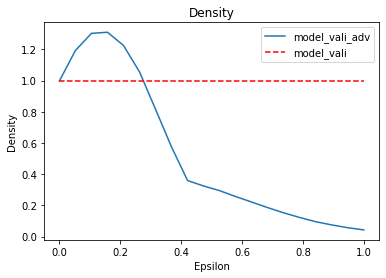

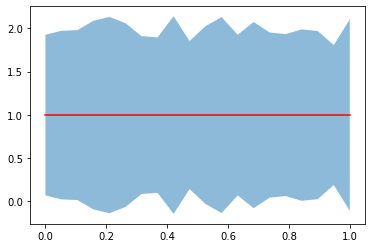

In [60]:
plt.figure(1)
plt.plot(epsilon, nmodel_vali_adv_density, label='model_vali_adv')
plt.plot(epsilon, np.repeat(nmodel_vali_density, len(epsilon)), ls='--',c='r', label='model_vali')
plt.xlabel("Epsilon")
plt.ylabel("Density")
plt.title("Density")
plt.legend()
#plt.fill_between(epsilon, nmodel_vali_adv_density+val_mean, nmodel_vali_adv_density-val_mean, alpha=0.2)

plt.figure(2)
plt.plot(epsilon, np.repeat(nmodel_vali_density, len(epsilon)), c='r')
plt.fill_between(epsilon, np.repeat(nmodel_vali_density, len(epsilon))+bmodel_vali_density, np.repeat(nmodel_vali_density, len(epsilon))-bmodel_vali_density, alpha=0.5)

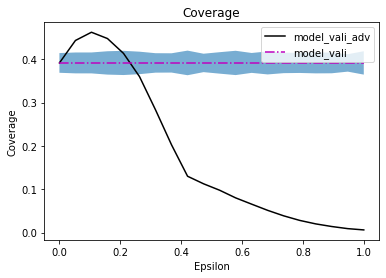

In [57]:
plt.figure(1)
plt.plot(epsilon, nmodel_vali_adv_cov, c='k', label='model_vali_adv')
plt.plot(epsilon, np.repeat(nmodel_vali_cov, len(epsilon)), ls="-.", c='m', label='model_vali')
plt.fill_between(epsilon, new[0,...], new[1,...], alpha=0.6)
plt.xlabel("Epsilon")
plt.ylabel("Coverage")
plt.title("Coverage")
plt.legend()

-------------------------------------------------------------------------------------------------------------------------------

# Boundary Attack

### Attack the model using validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

--------------------------------------------------------------------------------------------------------------------------

The steps implemedted for the FGSM attack remains the same, however, 2 points were changed

- the ```epsilon``` value is nullified i.e., **None** was specified.
- the model_dataset has 67000 images for the computation of metrics

The uncertainity band is implemented the same way as stated for FGSM attack


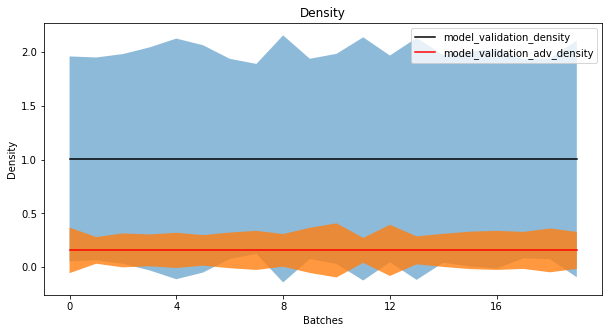

In [199]:
# plot density
plt.figure(figsize=(10,5))
plt.plot(range(len(derror)), dx, c='k', label='model_validation_density')
plt.fill_between(range(len(derror)), dx-derror, dx+derror, alpha=0.5)

plt.plot(range(len(derror_adv)), dadv_x, c='r', label='model_validation_adv_density')
plt.fill_between(range(len(derror_adv)), dadv_x-derror_adv, dadv_x+derror_adv, alpha=0.8)

plt.xticks(range(0,20,4))
plt.xlabel('Batches')
plt.ylabel('Density')
plt.title('Density')
plt.legend()
plt.savefig("BoundaryAttack_density.png")

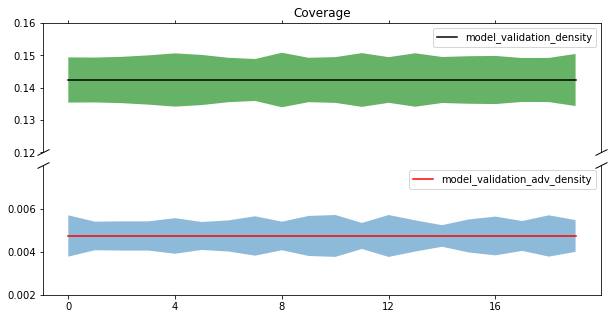

In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax1.plot(range(len(cerror)), cx, c='k', label='model_validation_density')
ax1.fill_between(range(len(cerror)), cx-cerror, cx+cerror, alpha=0.6, facecolor='g')
ax1.legend()
ax2.plot(range(len(cerror_adv)), cadv_x, c='r', label='model_validation_adv_density')
ax2.fill_between(range(len(cerror_adv)), cadv_x-cerror_adv, cadv_x+cerror_adv, alpha=0.5)
ax2.legend()
ax1.set_ylabel("Coverage")
ax1.set_title("Coverage")

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(.12, 0.16)  # outliers only
ax2.set_ylim(0.002, .008)  # most of the data
ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False) # don't put tick labels at the top
ax2.set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig("BoundaryAttack_coverage.png")